## Basic PWS data processing using PWSpy-QC 
___
<img src="https://hess.copernicus.org/articles/25/583/2021/hess-25-583-2021-avatar-web.png" alt="drawing" width="1300"/>

**Jochen Seidel**, Abbas El Hachem, Micha Eisele, András Bárdossy
___
University of Stuttgart

## How does a (Netatmo) PWS work? 

<img src="./pics/PWS.png" alt="drawing" width="1000"/>

## Why is it not advisable to use raw PWS data? Some typical (Netatmo) PWS errors:


### Many PWS are not installed/setup according to WMO standards

<img src="./pics/PWS_setup.png" alt="drawing" width="1000"/>

### Incorrect information about the location

<img src="./pics/PWS_movements.png" alt="PWS on the move" width="1000"/>

### Incorrect information about the location - "hot spots"

<img src="./pics/PWS_hotspots.png" alt="PWS on the move" width="1000"/>

### Data gaps and peaks

<img src="./pics/PWS_gaps.png" alt="PWS on the move" width="1000"/>

## The Bottom Line
### Due to the numerous potential errors sources the data from  Netatmo-PWS have to be QC and filtered! 

Overview of the three QC algorithms in [El Hachem et al. 2023](https://hess.copernicus.org/preprints/hess-2023-195/)

## 1. Loading PWS and auxilliary data (primary stations)

**Goal**: Load PWS and auxilliary data stored as csv as an `pandas.DataFrame` object and visualize the data

### 1.0 Import packages and adjust settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr
xr.set_options(display_style='text'); # Show xarray.Dataset representation as text

#import pycomlink as pycml

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np
import time
from scipy.spatial import cKDTree
from pykrige import OrdinaryKriging as OKpy
import tqdm
import os
import pandas as pd
import matplotlib as mpl

# OPENSENSE Sandbox tools 
# ToDo: Set link from local to github
import PWSpyqcFunctions as pyqc
import pycomlink as pycml

# Link to the data
main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"
# todo: change back to online source once everything is finished
#main_dir = r"/home/jose/Nextcloud/OPENSENSE/2023_06_Krakow/Sandbox/pws-pyqc/OpenSense/Data/"

PWSqc-QC specific settings 
(better after plotting?)

In [2]:
# maximun distance (meters) for which the indicator correlation is calculated
max_distance = 50000

# Precentile threshold for indicator correlation 
prob=0.99

# todo: chekc if and where this is needed
show_plot = True

# minimum number of records (in hours) with values (here 2 months)
min_req_ppt_vals = 2*30*24 

In [3]:
data_path = pycml.io.examples.get_example_data_path()  # get path to example data
print(data_path)

/home/jose/Nextcloud/OPENSENSE/TrainingSchool2023/notebooks/pycomlink/io/example_data


### 1.1 Load the csv data files

In [4]:
# Automatic weather satation data from KNMI Netherlands
path_primary_network = os.path.join(main_dir, r"AWS_stns_data.csv")
path_primary_metadata = os.path.join(main_dir, r"AWS_stns_coords.csv")   

# Data from 20 randomly chose radar grid cells as "primary stations 2" for the Amsterdam area
path_primary_network2 = os.path.join(main_dir, r"Radar_grid_cell_vals.csv")
path_primary_metadata2 = os.path.join(main_dir, r"selected_radar_grid_lonlat.csv") 


# PWS hourly data ()
path_pws_data = os.path.join(main_dir, r"AMS_PWS_hourly_shifted.csv")   
path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")

**&#8594;** each datasets consists of a metafile with coordinates and a data file with stations as columns and timestamps as rows (c.f. OPENSENSE White Paper)

**&#8594;** the Netatmo PWS data set used here is published by de [Vos (2019)](https://data.4tu.nl/articles/_/12703250/1)

**&#8594;** `pyqc.read_pcp_csv_file` and `read_metadata_csv_file` in the following code are functions based on `pandas.DataFrame` 

If you are familiar with python functions you can have a look at the file **PWSpyqcFunctions.py**

In [5]:
# read primary network 1
print('Reading first primary network data')
# pyqc.read_pcp_csv_file has 'latin-1' encoding in PWSpyqcFunctions.py
in_primary_pcp = pyqc.read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=';',
                           index_col=0)

# pyqc uses EPSG:25832, for Netherlands EPSG:28531 is used!
# Reads coordinate file and additionally coverts Lat/Lon to UTM 32
df_prim_coords, prim_coords_xy = pyqc.read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=';', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read primary network 2
print('Reading secondary primary network data')
in_primary_pcp_2 = pyqc.read_pcp_csv_file(path_to_file=path_primary_network2,
                           sep_type=';',
                           index_col=0)

df_prim_coords_2, prim_coords_xy_2 = pyqc.read_metadata_csv_file(
            path_primary_metadata2,
            sep_type=',', index_col=0,)
df_prim_coords_2.index = in_primary_pcp_2.columns

# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pyqc.read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=';',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pyqc.read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',
                           index_col=0)
df_pws_coords.index = df_pws_pcp_hourly.columns

Reading first primary network data
Reading secondary primary network data
Reading PWS data


### 1.2 How do the data look like?

In [6]:
# This shows the PWS data itself as described above
df_pws_pcp_hourly

,ams1,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams125,ams126,ams127,ams128,ams129,ams130,ams131,ams132,ams133,ams134
Time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 01:00:00,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 03:00:00,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 04:00:00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 05:00:00,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
2018-05-31 20:00:00,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2018-05-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.1,NaN,NaN,NaN,0.0,0.0


In [7]:
df_pws_pcp_hourly.describe()

,ams1,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams125,ams126,ams127,ams128,ams129,ams130,ams131,ams132,ams133,ams134
count,15802.000000,14217.000000,15808.000000,10804.000000,12463.000000,13596.000000,16497.000000,15627.000000,11710.000000,1841.000000,...,10531.000000,13425.000000,14714.000000,11517.000000,1934.000000,1023.000000,3397.000000,8526.000000,8731.000000,16549.000000
mean,0.081290,0.089915,0.081764,0.100704,0.085097,0.106146,0.065988,0.099592,0.087868,0.155470,...,0.086023,0.137145,0.085362,0.110187,0.086396,0.053245,0.074342,0.084037,0.087354,0.092683
std,0.387545,0.426993,0.413551,0.464482,0.395962,0.551481,0.367549,0.482112,0.427031,0.635277,...,0.410645,0.949273,0.472458,0.544546,0.458758,0.317535,0.299455,0.516298,0.494587,0.547407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.690000,15.660000,12.530000,13.430000,11.510000,16.470000,12.620000,13.430000,13.940000,8.180000,...,13.130000,41.210000,16.660000,21.510000,7.780000,5.350000,4.850000,13.840000,20.000000,20.300000


### Questions:

* What does count mean?
* Why are all the 75% percentiles 0.0?
* How can you display other percentiles, e.g. 0.99?

### 1.3 Plotting the data

### 1.3.1 Location of the stations

Plotting locations of all data


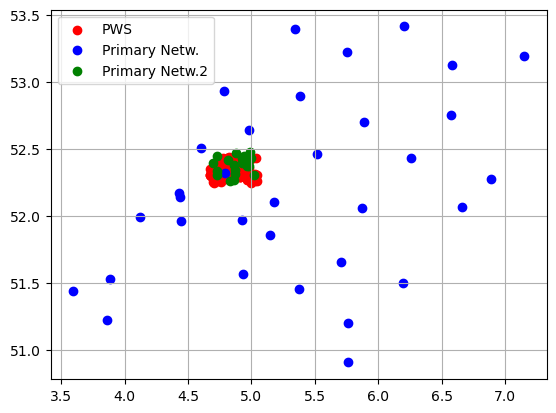

In [8]:
print('Plotting locations of all data')

pyqc.plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)

    


Plotting locations of data in and around Amsterdam


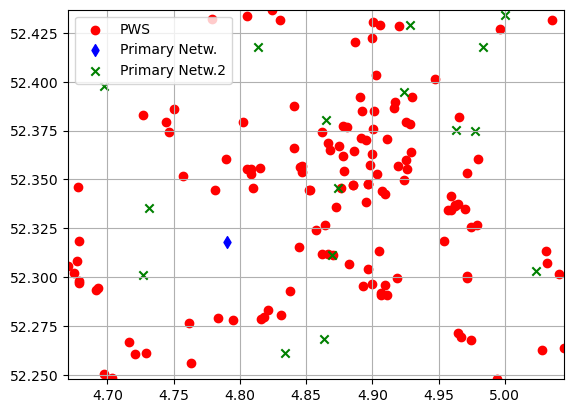

In [9]:
print('Plotting locations of data in and around Amsterdam')

pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)

### 1.3.2 Plotting the PWS data

<Axes: xlabel='Time', ylabel='mm'>

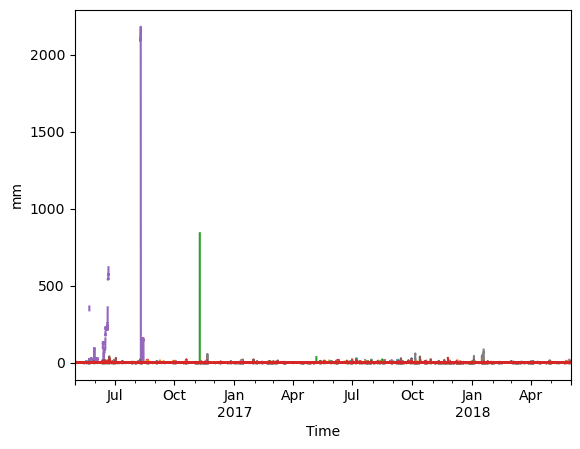

In [10]:
# Plotting all data in the DataFrame (combined plot with 134 stations does not really make sense...)
df_pws_pcp_hourly.plot(legend=False, ylabel='mm')

This does not really make sense with 134 stations.

+ What is the first thing we can observe here?

### Let's plot some individual stations

<Axes: title={'center': 'PWS ams18'}, xlabel='Time', ylabel='mm'>

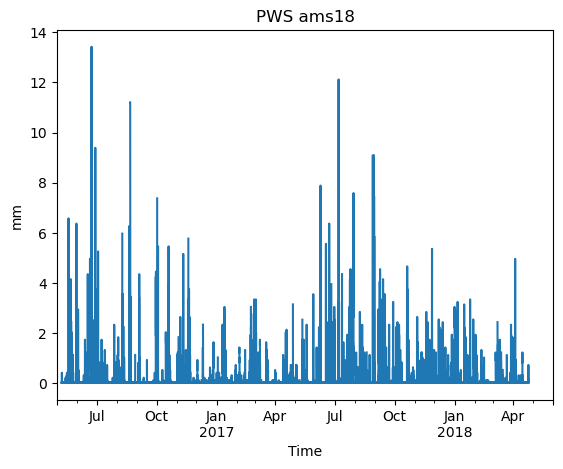

In [11]:
# PWS station ams18
df_pws_pcp_hourly['ams18'].plot(ylabel='mm', title='PWS ams18')


**&#8594;** This PWS hat a more or less continuous record (last part is missing) and looks ok at first sight

<Axes: title={'center': 'PWS ams46'}, xlabel='Time', ylabel='mm'>

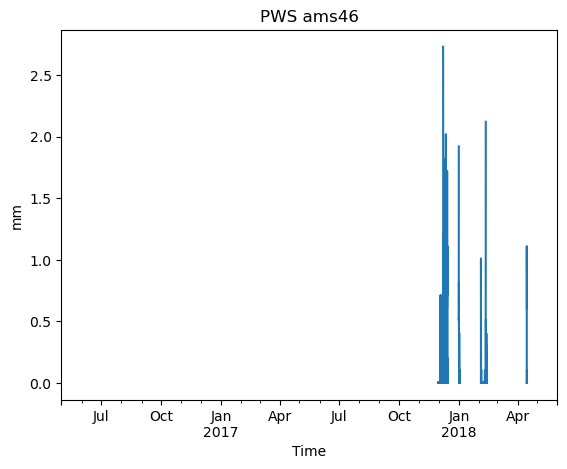

In [12]:
# PWS station ams46
df_pws_pcp_hourly['ams46'].plot(ylabel='mm', title='PWS ams46')

**&#8594;** This PWS has either low values or missing values, apparently no 0mm occur. Furthermore, this series is rather short.

<Axes: title={'center': 'PWS ams105'}, xlabel='Time', ylabel='mm'>

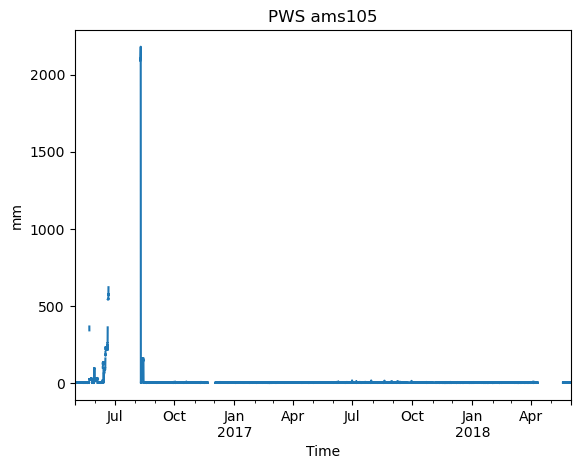

In [13]:
# PWS station ams105
df_pws_pcp_hourly['ams105'].plot(ylabel='mm', title='PWS ams105')

**&#8594;** This PWS has unrealstic data values and a large gap until September 2017. However, the data from September 2017 onwards seems ok.

### Exercises: 

+ Plot the data for an arbritatry PWS from the dataframe


+ Plot the data for the 'ams105' station from Sept 2017 onwards

**Hint:** For `pandas dataframes` this to simiar to slicing in `xarray`, i.e. datetimes as strings in square bracktes separated by a colon `['yyyy-mm-dd':'yyyy-mm-dd']`


+ Remove this station's data before Sep 2017 (maybe make a copy of the dataframe first...)

**Hint:** You need to select a time interval (like slicing above) for a station and set these values to NaN 

In [14]:
# Write code here:








**Caution:** Running the following cell will load the solution!

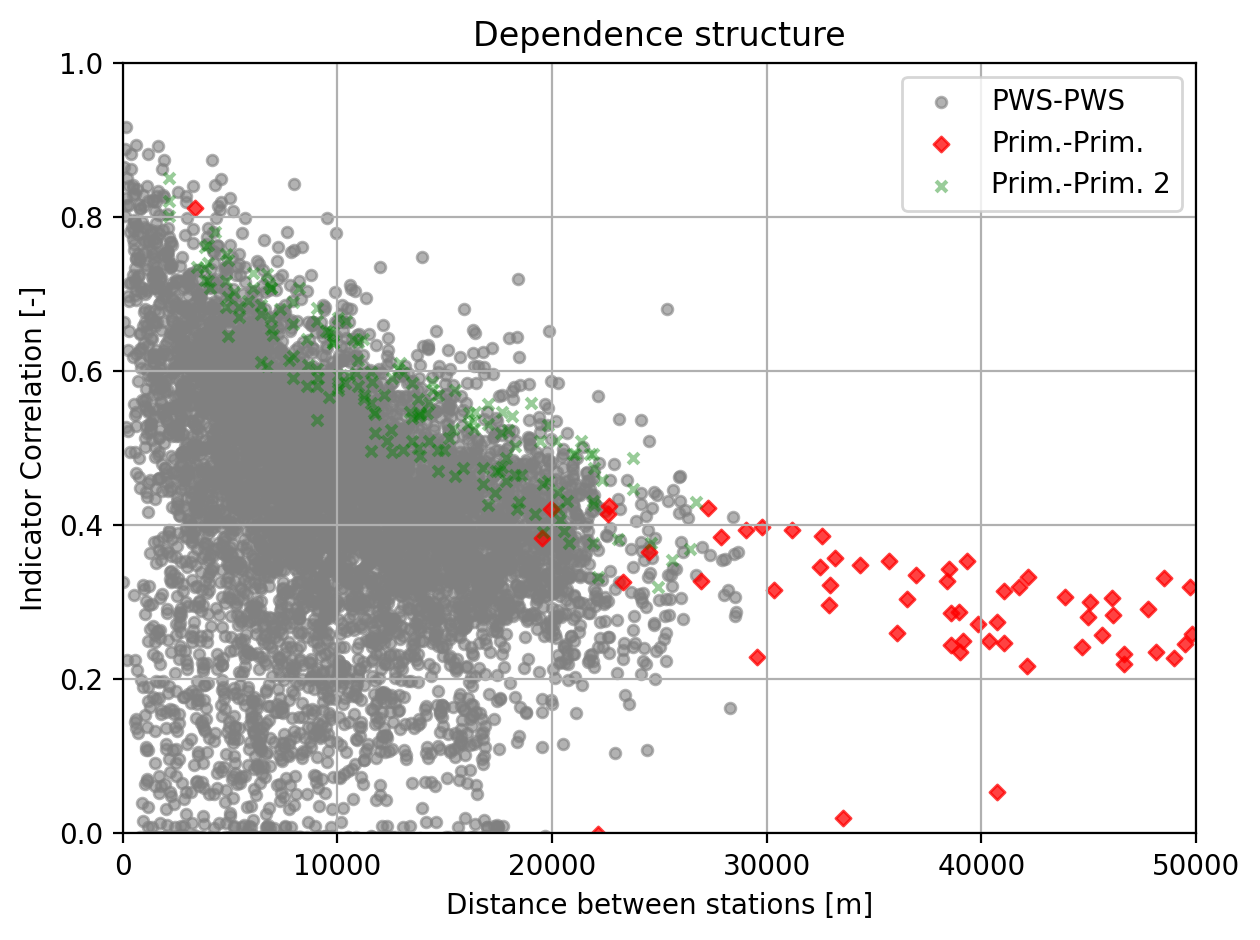

In [38]:
# %load 2-1-solution.py
#----------------------------------------------------------------- Solution for Excercise 2.1

pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2)


### Analysis of missing values (NaN)

In [18]:
# Sorted number and %-ages of missing values per station
pyqc.missing_values_table(df_pws_pcp_hourly)

Your selected dataframe has 134 columns.
There are 134 columns that have missing values.


,Missing Values,% of Total Values
ams45,17832,97.6
ams46,17783,97.4
ams77,17640,96.6
ams130,17240,94.4
ams110,16951,92.8
...,...,...
ams30,1658,9.1
ams11,1644,9.0
ams108,1569,8.6
ams22,1549,8.5


Text(0.5, 0, 'Number of NaN')

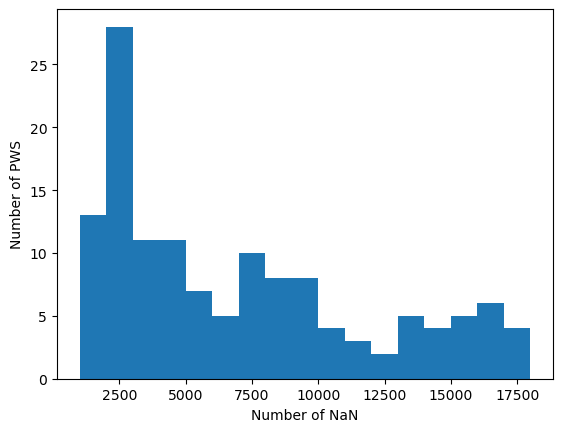

In [19]:
# Plot a histogram with number of NaN per station
plt.hist(df_pws_pcp_hourly.isna().sum(), bins = np.arange(1000,19000,1000))
plt.ylabel('Number of PWS')
plt.xlabel('Number of NaN')

### 1.4. Summary Part 1

+ Raw (Netatmo) PWS data are often erroneous and need quality control before used in applications
+ Simple analyis of common errors
+ csv format is also possible to use for OS-data, however netCDF has several advantages

## 2. First PWSpy-QC step: Indicator correlation based filter
The fist QC-filter of PWS-pyqc is based on indicator correlation patterns of the primary network (cf. [Bárdossy et al. 2021](https://doi.org/10.5194/hess-25-583-2021)). First, the data of the primary network are converted to 1 and 0 based on a threshhold, in this case the 99%-percentile. All values above this percentile are 1, all below 0. This indicator correaltion of the primay stations has a spatial structure, i.e. the correlation decreases with increasing distance

Calculating indicator correlation


  0%|                                                   | 0/133 [00:00<?, ?it/s]/home/jose/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jose/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████| 133/133 [00:11<00:00, 12.08it/s]


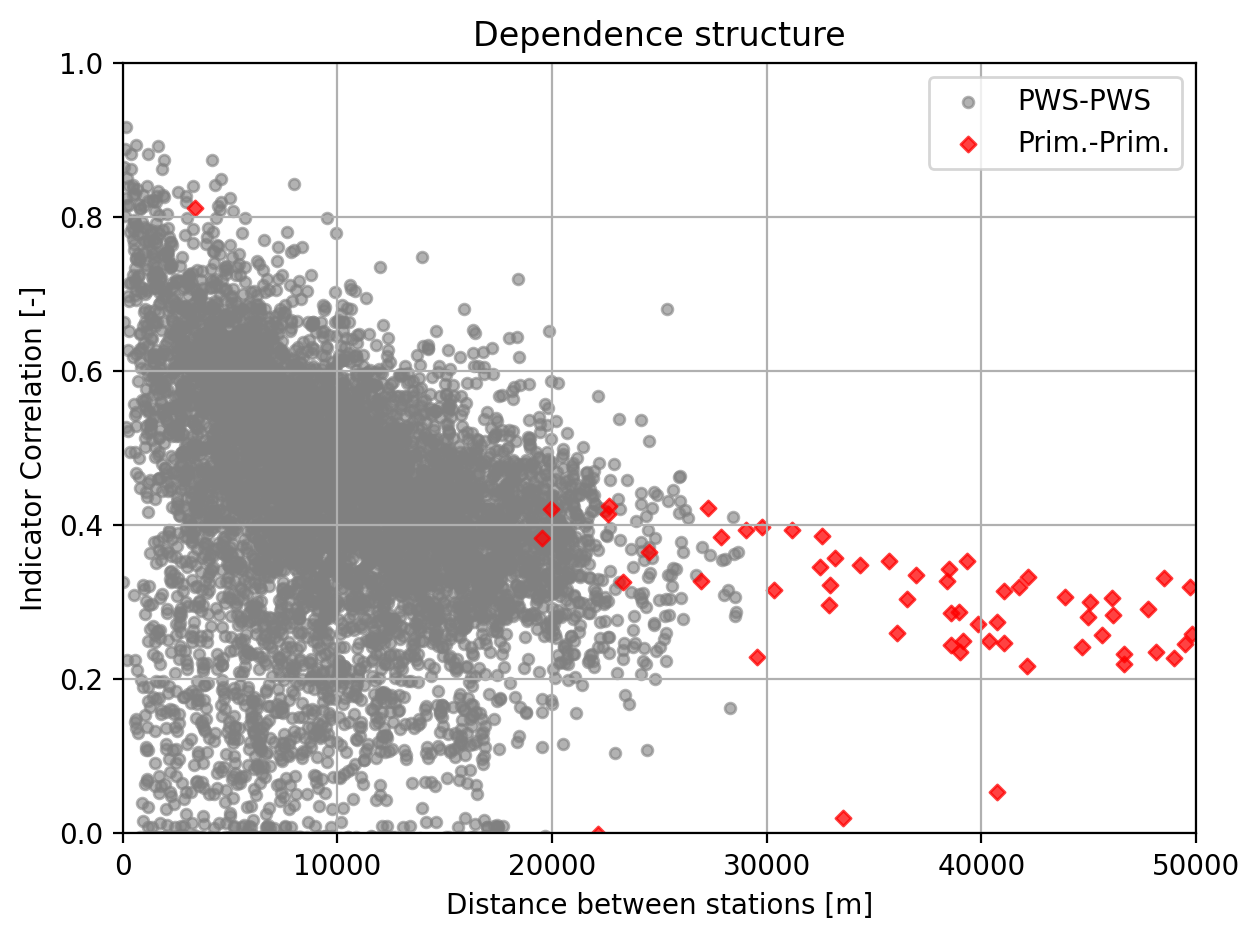

In [39]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')
dist_prim, corr_prim = pyqc.calc_indic_corr_all_stns(
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values, prob=0.99)

# calculate indicator correlation second primary network
dist_prim2, corr_prim2 = pyqc.calc_indic_corr_all_stns(
    coords_stns_xy=prim_coords_xy_2,
    pcp_vals=in_primary_pcp_2.values, prob=0.99)

# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = pyqc.calc_indic_corr_all_stns(
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

# plot indicator correlations
pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws)

We can see that there is a large gap up to 20 km in the primary network, hence there's information about the spatial structure missing. This is the reason why the data from the KMNI gauge adjusted radar product are used in addtion

### Excercise: 
+ Plot the dependece structure with the secondary primary network (i.e. data from radar pixels)

**Hint:** Click on the function in the cell below and use shift Tab shows the syntax that the functions expect. Add the corresponding parameters

In [ ]:
pyqc.plot_indic_coor()

**Caution:** Running the following cell will load the solution!

In [ ]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load 2-1-solution.py


As can be seen in the plot above, the primary stations have a certain dependence sturcture over distance. Most of the PWS as well, but there are also some PWS which do not follow this structure. When the indicator corrleation of a PWS next to a primary station is low, then it is likley that the PWS data are faulty. The first QC-filter pf PWS-pyqc now removes all PWS which do not show indicator correlations similiar to that of the reference data (primary stations).

### Applying the Indicator correlation based filter¶

100%|█████████████████████████████████████████| 134/134 [00:34<00:00,  3.91it/s]


Total Accepted 86 134


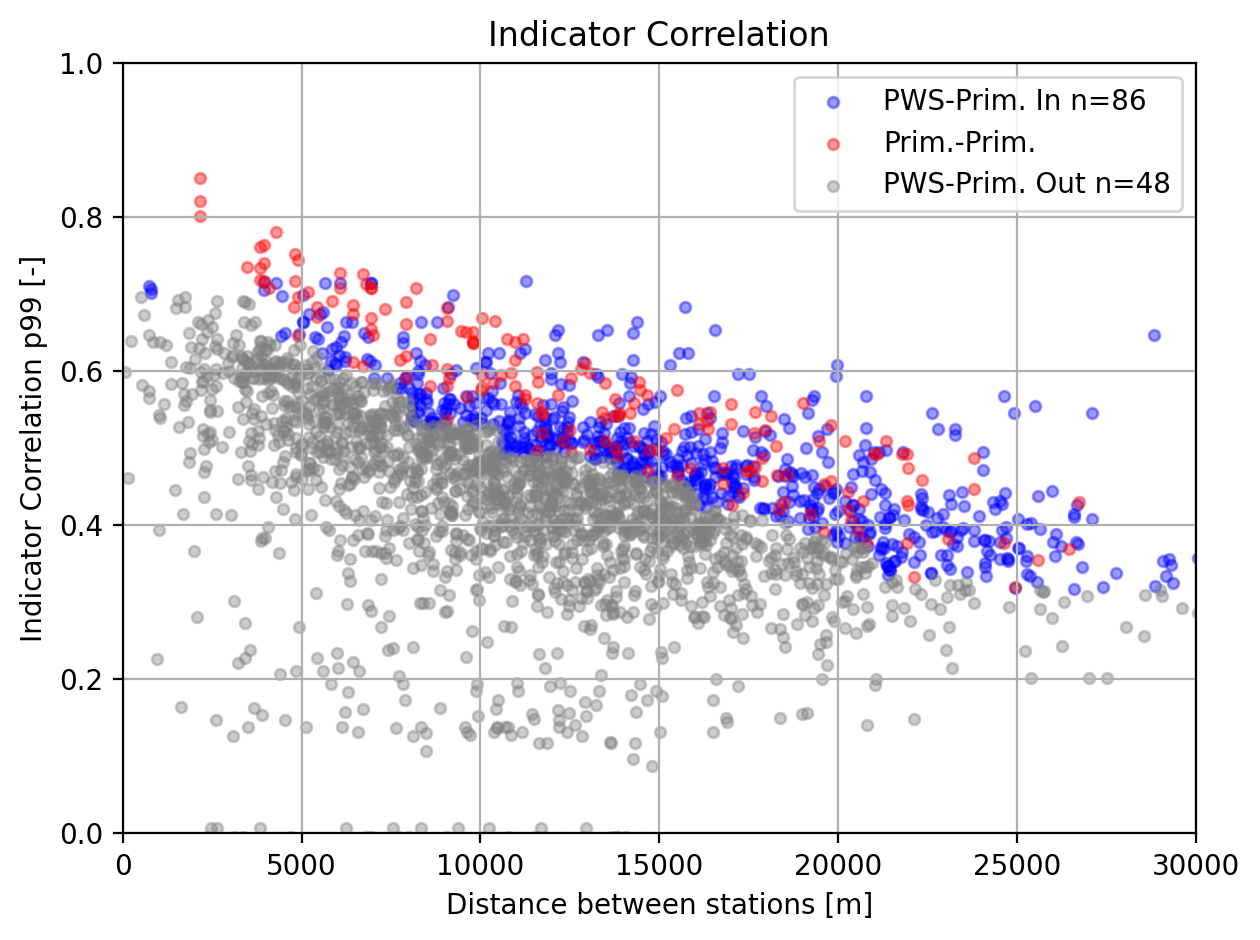

In [40]:
# apply indicator filter (using primary stations 2)

stn_in = pyqc.indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy_2,
                 prc_dwd=in_primary_pcp_2,
                     prob=0.99, max_distance=max_distance,
                     min_req_ppt_vals=2*24*30, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)

# what data type is stn_in
# Was ist tolerance? (1 muss größer als min) Parameter zum aus probieren

In [24]:
# list the accepted stations
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
pws_ids_accepted

Index(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams105', 'ams106', 'ams107', 'ams108', 'ams109',
       'ams111', 'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120',
       'ams123', 'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133',
       'ams134'],
      dtype='object')

This filter compares the PWS with all primary stations within the set `max_distance` (see above), i.e. if the indicator correlation low to the next primary stations the PWS might still be accepted if it fit's to a primary station further away. `threshold` -> how much lower an IC compared to the primary network is still accepted 

### Excercise:

+ Change the `max_distance` and `threshold` parameters and see how these influence the results

In [ ]:
# copy code for indicator filter here and change the threshold for the indicator correlation:







**Question:** Why do you have to decrease the threshold for increasing temporal aggregation, e.g. for daily data?

## 3. Bias Correction

PWS can over- or undererstimate the precepitation compared to a professional refernce station (panel b) in figure below). The reasons herefore are mayfold (c.f. Introduction). The goal is to correct the PWS distribution function usind the distribution function of neighbouring primary network stations. For more details see [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

<img src="./pics/bias.png" alt="drawing" width="800"/>


### Basic Scheme of the PWS-pyqc Bias Correction


<img src="./pics/bias_correction.png" alt="drawing" width="400"/>

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 108.79it/s]


Done converting primary network precipitaiton to quantile
Correcting  ams1 :  0 / 86
PWS DF shape to correct:  1405


100%|███████████████████████████████████████| 1405/1405 [00:46<00:00, 30.08it/s]


Needed time (s) 46.73


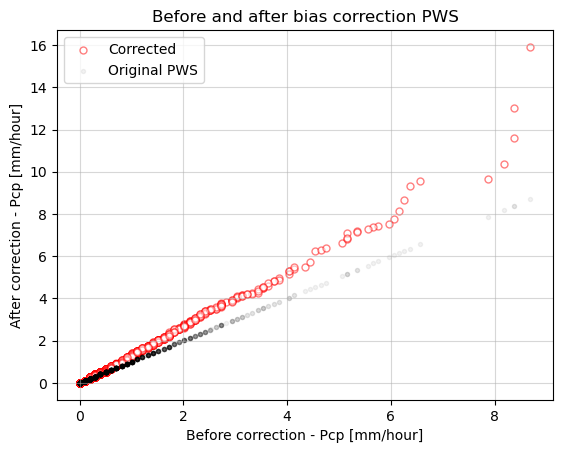

Correcting  ams2 :  1 / 86
PWS DF shape to correct:  1384


100%|███████████████████████████████████████| 1384/1384 [00:38<00:00, 35.54it/s]


Needed time (s) 38.97


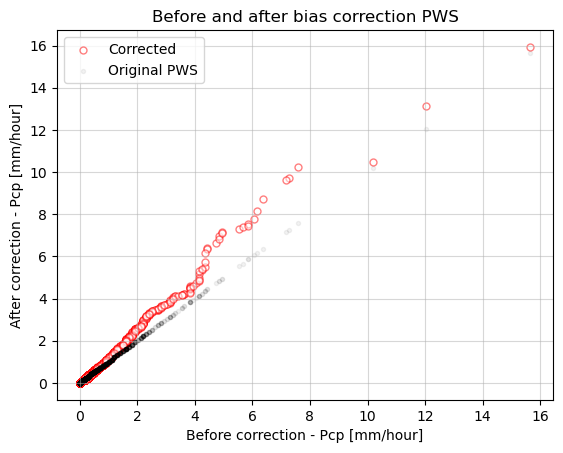

In [35]:
df_pws_bias_corrected = pyqc.bias_corr_pws_cdf(df_pws_raw=df_pws_pcp_hourly,
                        pws_ids_accepted=pws_ids_accepted,
                        df_pws_coords=df_pws_coords,                            
                        prim_coords_xy_2=prim_coords_xy_2,
                        in_primary_pcp_2=in_primary_pcp_2,
                        df_prim_coords_2=df_prim_coords_2,
                        nstns_correct=2,#len(pws_ids_accepted), #2,
                        plot_figures=True,
                        ppt_min_thr_0_vals=0.1,  # below it all values get p0/2
                        min_qt_to_correct=0.9,)

The bias correction is rather slow, that's why this is only shown for 2 stations. In both cases the PWS underestimates the precipitation and thus the values are corrected towards higher values.



### Excercise:

+ Plot the time series for PWS ams1 before and after the bias correction

  **Hint:** The bias correction function returns a new dataframe called `df_pws_bias_corrected`

In [ ]:
# Write code here:









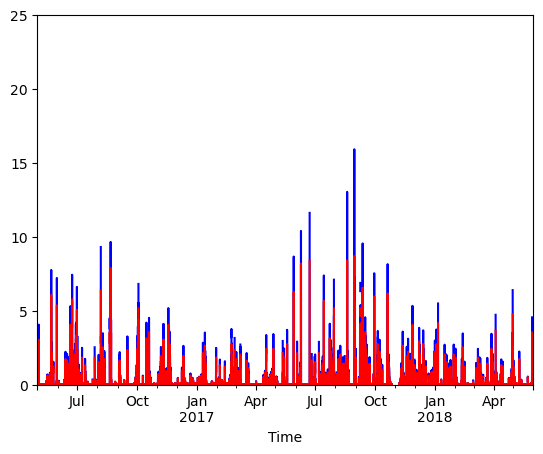

In [42]:
# %load 3-1-solution.py
#----------------------------------------------------------------- Solution Exercise 3.1

df_pws_pcp_shifted_corrected['ams1'].plot(color='blue')
df_pws_pcp_hourly['ams1'].plot(color='red')
plt.ylim(0,25)
plt.show()



A different faster bias correction function is used here to correct all stations. This data set will be used for interpolation in the next section

In [29]:
new_prc = pyqc.bias_correct(xy_net=pws_coords_xy,
                       prc_net=df_pws_pcp_hourly.values,
                       xy_prim=prim_coords_xy_2,
                       prc_prim=in_primary_pcp_2.values,
                           stn_in_bool=stn_in)

df_corrected = pd.DataFrame(index=df_pws_pcp_hourly.index,
                              data=new_prc,
                              columns =df_pws_pcp_hourly.columns)

# Für alle stationen?

  0%|                                                   | 0/134 [00:00<?, ?it/s]/home/jose/Nextcloud/OPENSENSE/TrainingSchool2023/notebooks/PWSpyqcFunctions.py:617: RuntimeWarning: invalid value encountered in multiply
  c = Sill * 1.0 / fac2 * fac1**v * Kv(v, fac1)
100%|████████████████████████████████████████| 134/134 [00:00<00:00, 292.34it/s]


## 4. Interpolate rainfall map from filtered and bias corrected PWS for a timestep

The goal is to correct the PWS distribution function usind the distribution function of neighboring primary network stations. For more details see [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

We will also use the IDW interpolation routine from `pycomlink`

In [30]:
todo: find an arbitrary time step where all stations have pcp. In the example below it is idx 18210

SyntaxError: invalid syntax (2817278891.py, line 1)

In [43]:
# Set up the IDW interpolator
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3)

#Create coordinates and data for interpolating values for a given timestamp/index
lon_pws=df_pws_coords.loc[pws_ids_accepted]
lat_pws=df_pws_coords.loc[pws_ids_accepted]
pcp_all=df_corrected.iloc[18210, stn_in].values

#Create indices for valid stations for the specific time step
idx=np.where(pcp_all>= 0)

R_grid = idw_interpolator(
    x=lon_pws.lon.values[idx], 
    y=lat_pws.lat.values[idx], 
    z=pcp_all[idx], 
    resolution=0.01,)

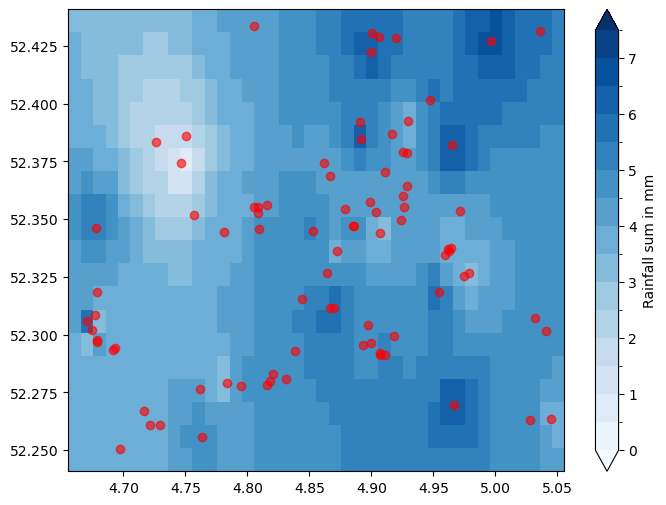

In [44]:
# Plot the interpolated map and the locations of the accepted PWS
bounds = np.arange(0, 8, 0.5)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='Blues',
    norm=norm,
)
plt.scatter(lon_pws.lon,lat_pws.lat, marker='o', color='r', alpha=.6)
fig.colorbar(pc, label='Rainfall sum in mm');
plt.show()


### Excercise:

+ Plot the original raw data for the same timestep and compare the results

**Hint:** copy & paste both cells from above and replace the corresponding variables under `#Create coordinates and data for interpolating values for a given timestamp/index` 


In [ ]:
# write/copy/change code here:

# Set up the IDW interpolator
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3)

#Create coordinates and data for interpolating values for a given timestamp/index
lon_pws=df_pws_coords.loc[:]
lat_pws=df_pws_coords.loc[:]
pcp_all=df_pws_pcp_hourly.iloc[18210, :].values

#Create indices for valid stations for the specific time step
idx=np.where(pcp_all>= 0)

R_grid = idw_interpolator(
    x=lon_pws.lon.values[idx], 
    y=lat_pws.lat.values[idx], 
    z=pcp_all[idx], 
    resolution=0.01,)






In [ ]:
# Plot the interpolated map and the locations of the accepted PWS
bounds = np.arange(0, 8, 0.5)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='Blues',
    norm=norm,
)
plt.scatter(lon_pws.lon,lat_pws.lat, marker='o', color='r', alpha=.6)
fig.colorbar(pc, label='Rainfall sum in mm');

In [ ]:
plt.show()

In [ ]:
#Plotting => before and after QC

In [36]:
!jupyter nbconvert --to slides 0_basic_pws_prcessing_PWSpy-QC_20230913.ipynb --post serve --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 0_basic_pws_prcessing_PWSpy-QC_20230913.ipynb to slides
[NbConvertApp] Writing 1731714 bytes to 0_basic_pws_prcessing_PWSpy-QC_20230913.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/0_basic_pws_prcessing_PWSpy-QC_20230913.slides.html
Use Control-C to stop this server
404 GET /favicon.ico (127.0.0.1) 0.57ms
404 GET /favicon.ico (127.0.0.1) 0.78ms
^C

Interrupted
